# 本筆記將帶大家用Keras建模
# 此範例使用MNIST手寫數字資料集

---

# 索引

[1. 資料準備](#I.-資料準備)
  * [1.a. 載入圖片](#1.a.-載入圖片)
  * [1.b. 利用Pandas可迅速了解每個資料夾裡面有幾張圖片](#1.b.-利用Pandas可迅速了解每個資料夾裡面有幾張圖片)
  * [1.c. 將圖片路徑資料切割成三份：取其80%做為train-data。 之後，剩下的20%中的10%做validation data，10%做test data](#1.c.-將圖片路徑資料切割成三份：取其80%做為train-data。-之後，剩下的20%中的10%做validation-data，10%做test-data)
  * [1.d. 將圖片載入，存成數值矩陣](#1.d.-將圖片載入，存成數值矩陣)
  

[2. Softmax Regression](#2.-Softmax-Regression)

  * [2.a. 將y 轉成one hot形式](#2.a.-將y-轉成one-hot形式)
  * [2.b. 開始建立模型](#2.b.-開始建立模型)
  * [2.c. 開始訓練模型](#2.c.-開始訓練模型)
  * [2.d. 檢視訓練好的模型用於test data有多少準確率](#2.d.-檢視訓練好的模型用於test-data有多少準確率)
  * [2.e. 檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok](#2.e.-檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok)
  * [2.f. 畫出模型訓練過程](#2.f.-畫出模型訓練過程)
  * [2.g. 儲存模型和權重](#2.g.-儲存模型和權重)
  * [2.h. 載入存好的模型和權重](#2.h.-載入存好的模型和權重)
  * [2.i. 輸出分類報告](#2.i.-輸出分類報告)
  
[3. Simple Convolutional Neural Network](#3.-Simple-Convolutional-Neural-Network)

  * [3.a. 建立模型](#3.a.-建立模型)
  * [3.b. 訓練模型](#3.b.-訓練模型)
  * [3.c. 檢視模型訓練結果](#3.c.-檢視模型訓練結果)
  * [3.d. 檢視模型準確率](#3.d.-檢視模型準確率)
  * [3.e. 檢視分類報告](#3.e.-檢視分類報告)
  
---

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KERAS_BACKEND"] = "torch"

import keras

keras.config.backend()

'torch'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
import pandas as pd
import sklearn

---

### 1. 資料準備

#### 1.a. 載入圖片

In [4]:
import os
from pathlib import Path

In [6]:
# def filePathsGen(rootPath):
#     """此函數將rootPath資料夾目錄中的所有圖片路徑資訊儲存至一個清單內。"""
#     paths = []
#     dirs = []
#     for dirPath, dirNames, fileNames in os.walk(rootPath):
#         for fileName in fileNames:
#             fullPath = os.path.join(dirPath, fileName)
#             paths.append((int(dirPath[len(rootPath)]), fullPath))
#         dirs.append(dirNames)
#     return dirs, paths

In [ ]:
data_dir = Path("/home/ds/BDSE_DL_v2025.02/datasets/mnist")
path_data = [
    (int(path.parent.stem), path) for path in sorted(data_dir.glob("**/*.jpg"))
]
dfPath = pd.DataFrame(
    path_data,
    columns=["class", "path"],
)

In [ ]:
!ls ../datasets/mnist

In [ ]:
# dirs, paths = filePathsGen("../datasets/mnist/")  # 載入圖片路徑

# dfPath = pd.DataFrame(paths, columns=["class", "path"])  # 圖片路徑存成Pandas資料表
# dfPath.head(3)  # 看資料表前3個row

[回索引](#索引)

#### 1.b. 利用Pandas可迅速了解每個資料夾裡面有幾張圖片

<Axes: xlabel='class'>

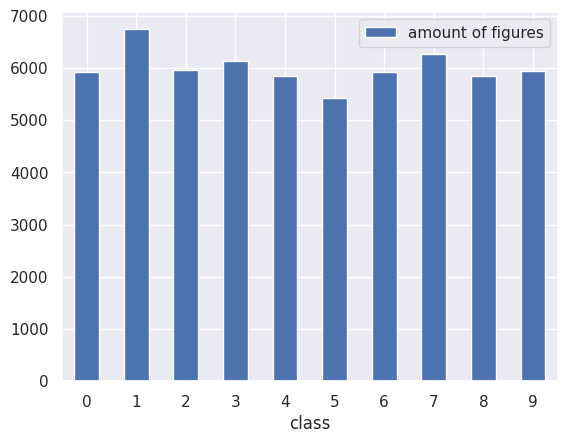

In [21]:
# 依照class分群後，數各群的數量，並繪圖
dfCountPerClass = dfPath.groupby("class").count()
dfCountPerClass.rename(columns={"path": "amount of figures"}, inplace=True)
dfCountPerClass.plot(kind="bar", rot=0)

[回索引](#索引)

####  1.c. 將圖片路徑資料切割成三份：取其80%做為train data。 之後，剩下的20%中取一半做validation data，另一半做test data

shape(all figures)=		 (60000, 2)
shape(fraction of figures)=	 (6000, 2)
shape(train)=			 (4800, 2)
shape(trainVal)=		 (600, 2)
shape(test)=			 (600, 2)


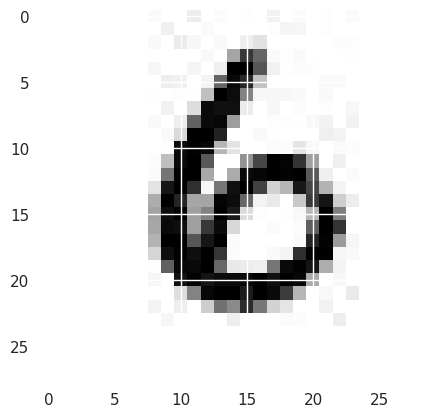

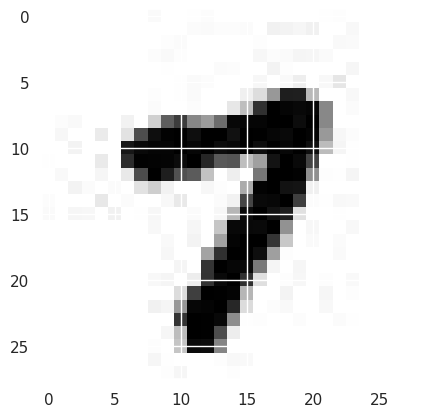

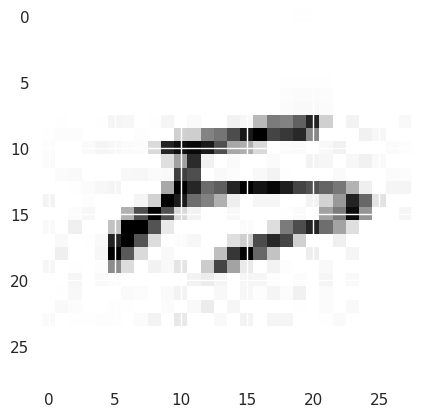

In [23]:
dfFrac = dfPath.sample(frac=0.1)  # 打亂一下path data

train = dfFrac.sample(frac=0.8)  # 將path data隨機取樣，80%的path data當train
test = dfFrac.drop(train.index)  # 20%的path data當test

trainVal = test.sample(frac=0.5)
test = test.drop(trainVal.index)

print("shape(all figures)=\t\t", dfPath.shape)
print("shape(fraction of figures)=\t", dfFrac.shape)
print("shape(train)=\t\t\t", train.shape)
print("shape(trainVal)=\t\t", trainVal.shape)
print("shape(test)=\t\t\t", test.shape)

# 隨便抓三張圖來看
for j in range(3):
    img = plt.imread(train["path"].iloc[j])
    plt.imshow(img, cmap="gray")
    plt.show()

[回索引](#索引)

####  1.d. 將圖片載入，存成數值矩陣

In [24]:
def dataLoad(dfPath):
    paths = dfPath["path"].values
    x = np.zeros((len(paths), 28, 28), dtype=np.float32)  # [num_paths, H=28, W=28]
    for j in range(len(paths)):
        x[j, :, :] = plt.imread(paths[j]) / 255.0  # [num_paths, H, W]

    y = dfPath["class"].values
    return x, y

In [25]:
trainX, trainY = dataLoad(train)
trainValX, trainValY = dataLoad(trainVal)
testX, testY = dataLoad(test)

In [26]:
print("train:\t", trainX.shape, trainY.shape)
print("trainVal:", trainValX.shape, trainValY.shape)
print("test:\t", testX.shape, testY.shape)

train:	 (4800, 28, 28) (4800,)
trainVal: (600, 28, 28) (600,)
test:	 (600, 28, 28) (600,)


In [28]:
testX[3].shape

(28, 28)

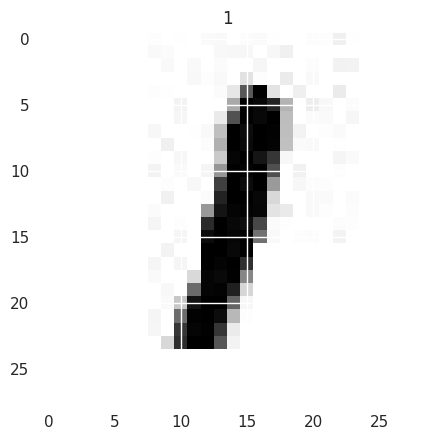

In [ ]:
idx = 11
plt.imshow(testX[idx], cmap="gray")
plt.title(testY[idx])
plt.show()

[回索引](#索引)

## 2. Softmax Regression

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD

#### 2.a. 將y 轉成one hot形式

In [37]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
trainYOneHot = enc.fit_transform(trainY.reshape(-1, 1)).toarray()

trainValYOneHot = enc.fit_transform(trainValY.reshape(-1, 1)).toarray()

testYOneHot = enc.fit_transform(testY.reshape(-1, 1)).toarray()

[回索引](#索引)

#### 2.b. 開始建立模型

In [39]:
from keras.layers import Flatten

In [41]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))  # [BS, 28, 28] -> [BS, 28*28]
model.add(Dense(10, activation="softmax"))  # [BS, 28*28] -> [BS, 10]

sgd = SGD(learning_rate=0.05)

model.compile(
    optimizer=sgd,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)  # 告知模型訓練方式

In [42]:
# 檢視一下所訓練的模型
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

[回索引](#索引)

#### 2.c. 開始訓練模型

In [43]:
hist = model.fit(
    trainX,
    trainYOneHot,
    epochs=20,
    batch_size=128,
    validation_data=(trainValX, trainValYOneHot),
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1607 - loss: 4.0779 - val_accuracy: 0.3833 - val_loss: 3.7560
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3473 - loss: 3.7528 - val_accuracy: 0.4517 - val_loss: 3.0621
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5514 - loss: 2.7131 - val_accuracy: 0.6600 - val_loss: 2.6450
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6508 - loss: 2.3553 - val_accuracy: 0.6517 - val_loss: 2.6565
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6524 - loss: 2.3666 - val_accuracy: 0.7450 - val_loss: 2.4503
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6849 - loss: 2.2907 - val_accuracy: 0.6567 - val_loss: 2.5270
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7208 - loss: 2.0940 - val_accuracy: 0.7083 - val_loss: 2.4636
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7283 - loss: 2.2338 - val_accuracy: 0.7083 - val_loss:

[回索引](#索引)

#### 2.d. 檢視訓練好的模型用於test data有多少準確率

In [44]:
score = model.evaluate(testX, testYOneHot, batch_size=128)
print()
print("\nloss=%s \naccuracy=%s" % (score[0], score[1]))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7981 - loss: 1.7214


loss=1.9846936464309692 
accuracy=0.778333306312561


[回索引](#索引)

#### 2.e. 檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok

In [ ]:
_pred_y = (
    model(
        # np.expand_dims(trainValX[j], axis=0), # [H, W] -> [1, H, W]
        trainValX,  # [num_samples, H, W]
    )
    .cpu()
    .detach()
    .numpy()
    .argmax(axis=-1)
)
_true_y = trainValY

accuracy = (_true_y == _pred_y).mean()
accuracy

In [ ]:
for j in range(50):
    predY = model.predict(trainValX[j : j + 1, :]).argmax()
    trueY = trainValYOneHot[j].argmax()
    print(predY, trueY, end="\t")

[回索引](#索引)

#### 2.f. 畫出模型訓練過程

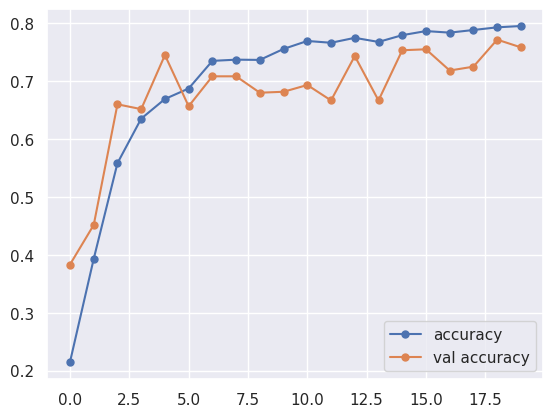

In [72]:
plt.plot(hist.history["accuracy"], ms=5, marker="o", label="accuracy")
plt.plot(hist.history["val_accuracy"], ms=5, marker="o", label="val accuracy")
plt.legend()
plt.show()

[回索引](#索引)

#### 2.g. 儲存模型和權重

In [ ]:
import json

with open("first_try.json", "w") as jsOut:
    json.dump(model.to_json(), jsOut)

model.save_weights("first_try.h5")

[回索引](#索引)

#### 2.h. 載入存好的模型和權重

In [ ]:
from keras.models import model_from_json

In [ ]:
with open("first_try.json", "r") as jsIn:
    modelJson = json.load(jsIn)

modelLoaded = model_from_json(modelJson)
modelLoaded.load_weights("first_try.h5")

modelLoaded.summary()

[回索引](#索引)

#### 2.i. 輸出分類報告

In [73]:
from sklearn.metrics import classification_report

predY = model.predict(testX).argmax(axis=1)
print(classification_report(testY, predY))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.89      0.93      0.91        61
           2       0.87      0.87      0.87        55
           3       0.83      0.83      0.83        59
           4       0.73      0.96      0.83        56
           5       0.53      0.71      0.61        58
           6       0.84      0.95      0.89        61
           7       0.91      0.92      0.91        74
           8       0.60      0.93      0.73        57
           9       1.00      0.64      0.78        61

    accuracy                           0.78       600
   macro avg       0.72      0.77      0.74       600
weighted avg       0.73      0.78      0.74       600



/home/ds/dl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ds/dl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ds/dl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[回索引](#索引)

## 3. Simple Convolutional Neural Network

In [74]:
trainX = trainX.reshape(*trainX.shape, 1)
trainValX = trainValX.reshape(*trainValX.shape, 1)
testX = testX.reshape(*testX.shape, 1)

In [75]:
trainX.shape

(4800, 28, 28, 1)

#### 3.a. 建立模型

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import Activation
from keras.optimizers import SGD, Adam, Adamax

input_shape = (28, 28, 1)

model = Sequential()

# conv1
model.add(
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape)
)

# conv2
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
# pool1
model.add(MaxPooling2D(pool_size=(2, 2)))
# conv3
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
# pool2
model.add(MaxPooling2D(pool_size=(2, 2)))
# dropout1
model.add(Dropout(0.5))
model.add(Flatten())
# dense1
model.add(Dense(128, activation="relu"))
# dropout2
model.add(Dropout(0.5))
# dense2
model.add(Dense(10, activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.05),
    metrics=["accuracy"],
)

[回索引](#索引)

#### 3.b. 訓練模型

In [ ]:
%%time 
hist = model.fit(trainX, trainYOneHot, 
                 epochs=30,
                 batch_size=128,
                 validation_data=(trainValX,trainValYOneHot),)

[回索引](#索引)

#### 3.c. 檢視模型訓練結果

In [ ]:
plt.plot(hist.history["accuracy"], ms=5, marker="o", label="accuracy")
plt.plot(hist.history["val_accuracy"], ms=5, marker="o", label="val accuracy")
plt.legend()
plt.show()

[回索引](#索引)

#### 3.d. 檢視模型準確率

In [ ]:
score = model.evaluate(testX, testYOneHot, batch_size=128)
print()
print("\nloss=%s \naccuracy=%s" % (score[0], score[1]))

[回索引](#索引)

#### 3.e. 檢視分類報告

In [ ]:
from sklearn.metrics import classification_report

predY = model.predict(testX).argmax(axis=1)
print(classification_report(testY, predY))

[回索引](#索引)

#### 練習

調整參數。嘗試增加或減少模型複雜度，並再次訓練，看模型準確度能否有所提升。